In [2]:
import pandas as pd
import numpy as np

import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error,  r2_score
from sklearn.mixture import GaussianMixture
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LassoCV
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess
import statsmodels.api as sm

In [3]:
# import data
movies = pd.read_csv("../data/cleaned_movies.csv")

In [4]:
# Parse release date to get month
movies["release_date_parsed"] = pd.to_datetime(movies["release_date"])
movies["release_month"] = movies["release_date_parsed"].dt.month

# Linear regression on log10_tickets_sold
formula = (
    "log10_tickets_sold ~ Year + release_month"
    " + C(Distributor) + C(Genre) + C(MPAA)"
    " + title_has_man + title_has_love + title_has_life"
)

ols_model = smf.ols(formula, data=movies).fit()

# Full regression summary
print(ols_model.summary())

# AIC & BIC
print(f"  AIC : {ols_model.aic:.2f}")
print(f"  BIC : {ols_model.bic:.2f}")


                            OLS Regression Results                            
Dep. Variable:     log10_tickets_sold   R-squared:                       0.680
Model:                            OLS   Adj. R-squared:                  0.649
Method:                 Least Squares   F-statistic:                     21.66
Date:                Thu, 25 Dec 2025   Prob (F-statistic):               0.00
Time:                        20:39:02   Log-Likelihood:                -7730.2
No. Observations:                6335   AIC:                         1.659e+04
Df Residuals:                    5768   BIC:                         2.042e+04
Df Model:                         566                                         
Covariance Type:            nonrobust                                         
                                                                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

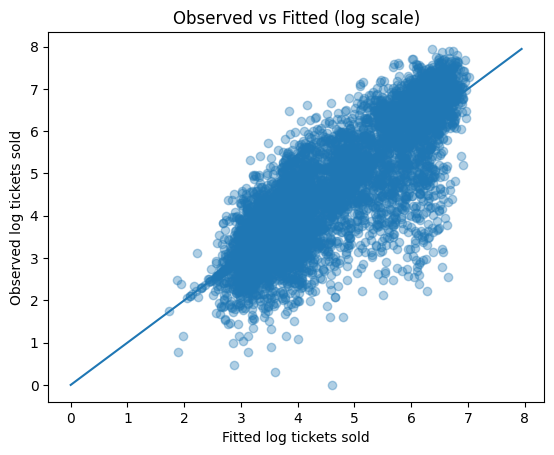

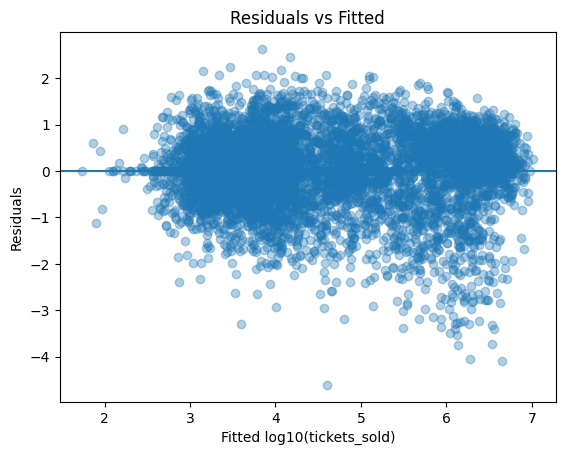

In [8]:
# --- Plots: model vs data ---
y = ols_model.model.endog        # observed log10_tickets_sold used in fit
yhat = ols_model.fittedvalues    # fitted log10_tickets_sold
resid = ols_model.resid          # residuals

# 1) Observed vs Fitted (log10 scale)
plt.figure()
plt.scatter(yhat, y, alpha=0.35)
lo = min(y.min(), yhat.min())
hi = max(y.max(), yhat.max())
plt.plot([lo, hi], [lo, hi])
plt.xlabel("Fitted log tickets sold")
plt.ylabel("Observed log tickets sold")
plt.title("Observed vs Fitted (log scale)")
plt.show()

# 2) Residuals vs Fitted
plt.figure()
plt.scatter(yhat, resid, alpha=0.35)
plt.axhline(0)
plt.xlabel("Fitted log10(tickets_sold)")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted")
plt.show()



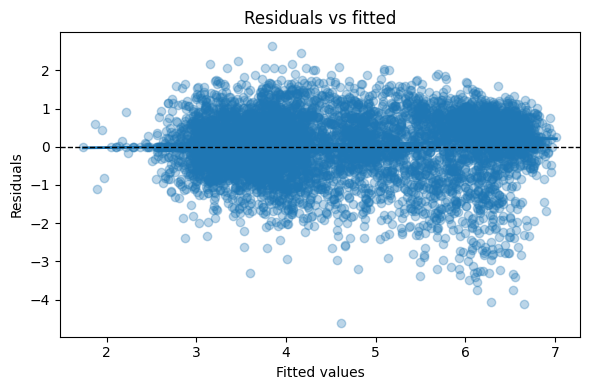

<Figure size 600x600 with 0 Axes>

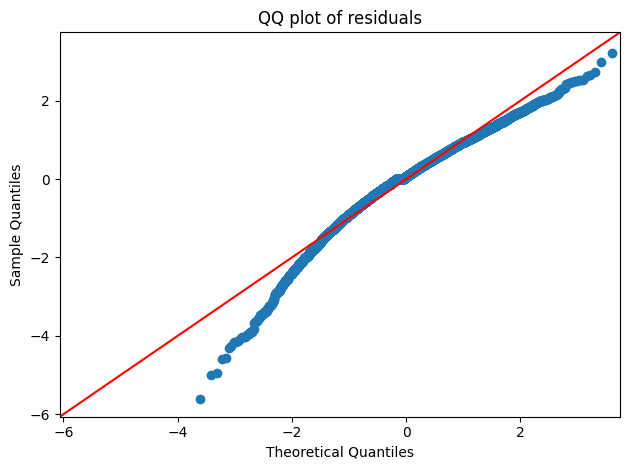

In [ ]:
fitted = ols_model.fittedvalues
resid  = ols_model.resid

# Residuals vs fitted plot
plt.figure(figsize=(6, 4))
plt.scatter(fitted, resid, alpha=0.3)
smoothed = lowess(resid, fitted, frac=0.3)
plt.plot(smoothed[:, 0], smoothed[:, 1], linewidth=2)

plt.axhline(0, color="k", linewidth=1, linestyle="--")
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs fitted")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 6))
sm.qqplot(resid, line="45", fit=True)
plt.title("QQ plot of residuals")
plt.tight_layout()
plt.show()

In [ ]:
# Lasso Regression
# release month
movies["release_date_parsed"] = pd.to_datetime(movies["release_date"])
movies["release_month"] = movies["release_date_parsed"].dt.month

y = movies["log10_tickets_sold"].values

feature_cols = [
    "Year",
    "release_month",
    "Distributor",
    "Genre",
    "MPAA",
    "title_has_man",
    "title_has_love",
    "title_has_life",
    "title_has_3d",
    "title_has_story",
]

X = movies[feature_cols].copy()

numeric_features = [
    "Year",
    "release_month",
    "title_has_man",
    "title_has_love",
    "title_has_life",
    "title_has_3d",
    "title_has_story",
]
categorical_features = ["Distributor", "Genre", "MPAA"]

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), categorical_features),
    ]
)

lasso = LassoCV(cv=5, random_state=0)

lasso_pipe = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", lasso),
    ]
)

lasso_pipe.fit(X, y)

y_hat = lasso_pipe.predict(X)
rmse_lasso = mean_squared_error(y, y_hat)
r2_lasso = r2_score(y, y_hat)

print(f"Lasso alpha: {lasso_pipe.named_steps['model'].alpha_:.6f}")
print(f"Lasso RMSE (log10 scale): {rmse_lasso:.4f}")
print(f"Lasso R^2 (log10 scale):  {r2_lasso:.4f}")

# retrieve non-zero coefficients
ct = lasso_pipe.named_steps["preprocess"]
feature_names = ct.get_feature_names_out()
coef = lasso_pipe.named_steps["model"].coef_

nonzero_idx = np.where(coef != 0)[0]
selected_features = [(feature_names[i], coef[i]) for i in nonzero_idx]

print("\nNon-zero Lasso coefficients (after encoding):")
for name, c in selected_features:
    print(f"{name:40s} {c: .4f}")


Lasso alpha: 0.000338
Lasso RMSE (log10 scale): 0.7282
Lasso R^2 (log10 scale):  0.6502

Non-zero Lasso coefficients (after encoding):
num__Year                                -0.0499
num__release_month                       -0.0939
num__title_has_man                        0.0035
num__title_has_love                       0.0048
num__title_has_life                      -0.0134
num__title_has_3d                        -0.0109
num__title_has_story                     -0.0108
cat__Distributor_20th Century Fox         2.1351
cat__Distributor_3D Entertainment         1.4049
cat__Distributor_A24                      0.7798
cat__Distributor_APD/Cinema Conservancy  -0.0816
cat__Distributor_Abkco Films             -0.1286
cat__Distributor_Abramorama Films         0.2698
cat__Distributor_AdLab Films              0.7528
cat__Distributor_Afterlight Pictures     -0.6360
cat__Distributor_Alive Mind              -0.0217
cat__Distributor_Alliance Films           0.4173
cat__Distributor_Aloha Releasing

In [ ]:
# Gaussian mixture model on log10_tickets_sold to separate groups
y = movies["log10_tickets_sold"].values.reshape(-1, 1)

gmm = GaussianMixture(
    n_components=2,
    covariance_type="full",
    random_state=0,
)
gmm.fit(y)

means = gmm.means_.ravel()
weights = gmm.weights_.ravel()
variances = gmm.covariances_.reshape(-1)

print("\nGaussian mixture on log10_tickets_sold (2 components):")
for k in range(gmm.n_components):
    print(
        f"  Component {k+1}: weight={weights[k]:.3f}, "
        f"mean={means[k]:.3f}, var={variances[k]:.3f}"
    )

print(f"\nGMM AIC: {gmm.aic(y):.2f}")
print(f"GMM BIC: {gmm.bic(y):.2f}")


Gaussian mixture on log10_tickets_sold (2 components):
  Component 1: weight=0.346, mean=6.192, var=0.635
  Component 2: weight=0.654, mean=3.719, var=0.732

GMM AIC: 22967.89
GMM BIC: 23001.92


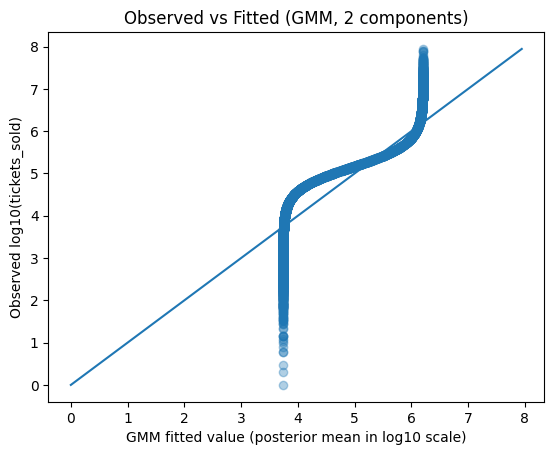

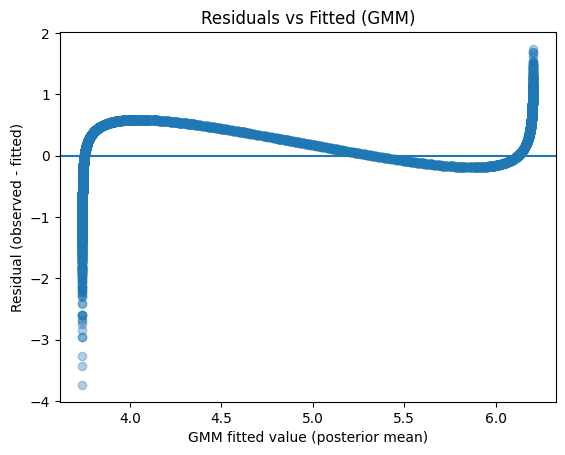

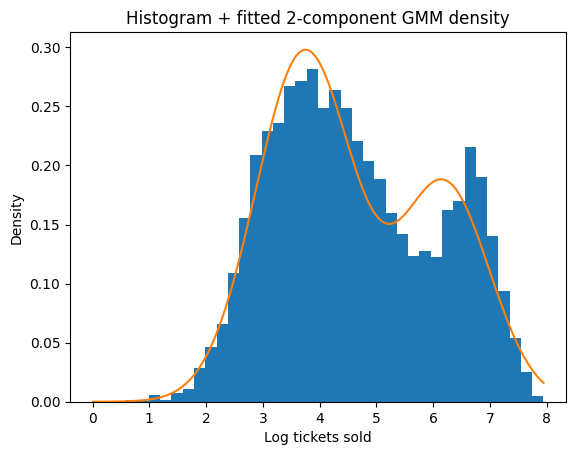

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# data (1D)
y = movies["log10_tickets_sold"].dropna().to_numpy()
y2d = y.reshape(-1, 1)

gmm = GaussianMixture(n_components=2, covariance_type="full", random_state=0)
gmm.fit(y2d)

# "fitted values" analogue: posterior mean E[Y | component responsibilities]
resp = gmm.predict_proba(y2d)  # (n, 2)
means = gmm.means_.ravel()     # (2,)
yhat = resp @ means            # (n,)

# 1) Observed vs "Fitted" (posterior mean)
plt.figure()
plt.scatter(yhat, y, alpha=0.35)
lo = min(y.min(), yhat.min())
hi = max(y.max(), yhat.max())
plt.plot([lo, hi], [lo, hi])
plt.xlabel("GMM fitted value (posterior mean in log10 scale)")
plt.ylabel("Observed log10(tickets_sold)")
plt.title("Observed vs Fitted (GMM, 2 components)")
plt.show()

# 2) Residual-like plot: y - yhat vs yhat
plt.figure()
plt.scatter(yhat, y - yhat, alpha=0.35)
plt.axhline(0)
plt.xlabel("GMM fitted value (posterior mean)")
plt.ylabel("Residual (observed - fitted)")
plt.title("Residuals vs Fitted (GMM)")
plt.show()

# 3) Histogram + fitted mixture density (nice sanity check)
xs = np.linspace(y.min(), y.max(), 500)
weights = gmm.weights_.ravel()
stds = np.sqrt(gmm.covariances_.reshape(-1))  # 2 std devs for 1D full cov

pdf = np.zeros_like(xs)
for w, m, s in zip(weights, means, stds):
    pdf += w * norm.pdf(xs, loc=m, scale=s)

plt.figure()
plt.hist(y, bins=40, density=True)
plt.plot(xs, pdf)
plt.xlabel("Log tickets sold")
plt.ylabel("Density")
plt.title("Histogram + fitted 2-component GMM density")
plt.show()


In [ ]:
movies["gmm_component"] = gmm.predict(y)  # 0 or 1

# Regression within each component
for k in [0, 1]:
    sub = movies[movies["gmm_component"] == k]
    print(f"\nComponent {k} (n = {len(sub)}):")

    model_k = smf.ols(formula, data=sub).fit()
    print(model_k.summary())


Component 0 (n = 2196):
                            OLS Regression Results                            
Dep. Variable:     log10_tickets_sold   R-squared:                       0.515
Model:                            OLS   Adj. R-squared:                  0.480
Method:                 Least Squares   F-statistic:                     14.86
Date:                Sun, 14 Dec 2025   Prob (F-statistic):          1.90e-228
Time:                        20:28:21   Log-Likelihood:                -1388.9
No. Observations:                2189   AIC:                             3072.
Df Residuals:                    2042   BIC:                             3908.
Df Model:                         146                                         
Covariance Type:            nonrobust                                         
                                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------

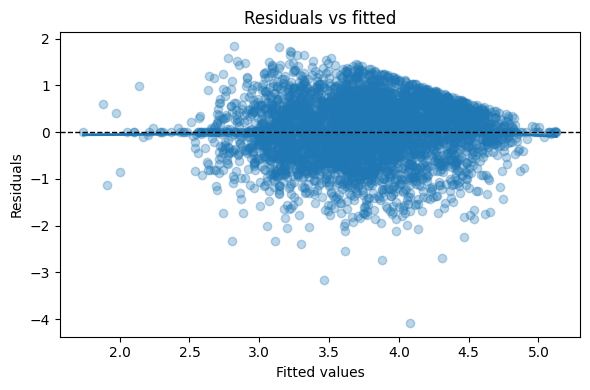

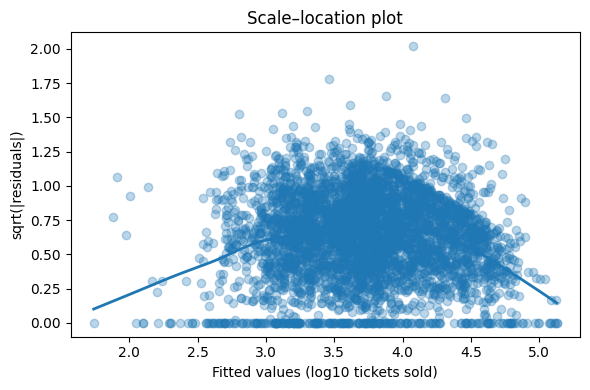

<Figure size 600x600 with 0 Axes>

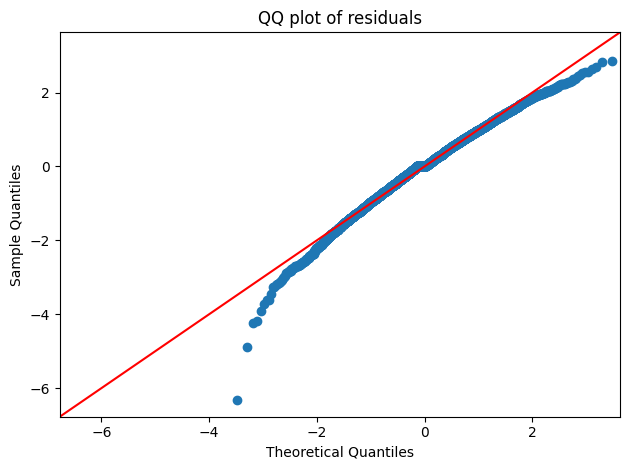

In [ ]:
fitted = model_k.fittedvalues
resid  = model_k.resid

# Residuals vs fitted plot
plt.figure(figsize=(6, 4))
plt.scatter(fitted, resid, alpha=0.3)
# smooth trend line
smoothed = lowess(resid, fitted, frac=0.3)
plt.plot(smoothed[:, 0], smoothed[:, 1], linewidth=2)

plt.axhline(0, color="k", linewidth=1, linestyle="--")
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs fitted")
plt.tight_layout()
plt.show()


# Scale–location plot
plt.figure(figsize=(6, 4))
abs_sqrt_resid = np.sqrt(np.abs(resid))
plt.scatter(fitted, abs_sqrt_resid, alpha=0.3)
smoothed2 = lowess(abs_sqrt_resid, fitted, frac=0.3)
plt.plot(smoothed2[:, 0], smoothed2[:, 1], linewidth=2)

plt.xlabel("Fitted values (log10 tickets sold)")
plt.ylabel("sqrt(|residuals|)")
plt.title("Scale–location plot")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 6))
sm.qqplot(resid, line="45", fit=True)
plt.title("QQ plot of residuals")
plt.tight_layout()
plt.show()